# bt

- http://pmorissette.github.io/bt/index.html

In [67]:
import bt
import pandas as pd

from utils import symbols

%matplotlib inline

## SMA strategy

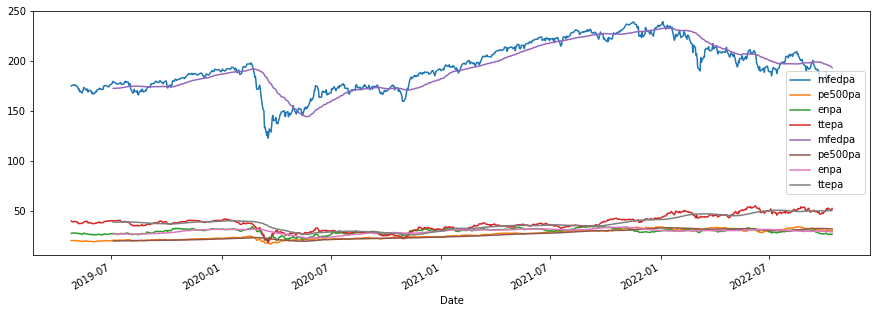

In [68]:
data = bt.get(','.join(symbols['stocks']['symbols']), start='2015-01-01')

sma = data.rolling(50).mean()
plot = bt.merge(data, sma).plot(figsize=(15, 5))

<AxesSubplot:title={'center':'Equity Progression'}>

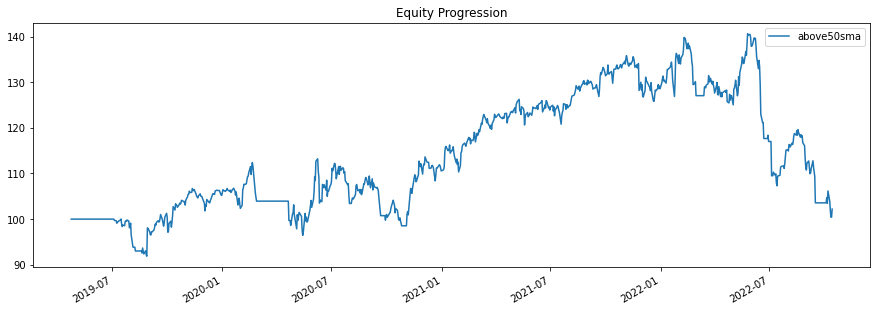

In [69]:
s = bt.Strategy(
    'above50sma',
    [
        bt.algos.SelectWhere(data > sma),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ]
)

t = bt.Backtest(s, data)
res = bt.run(t)
res.plot()

In [70]:
res.display()

Stat                 above50sma
-------------------  ------------
Start                2019-04-24
End                  2022-10-14
Risk-free rate       0.00%

Total Return         2.19%
Daily Sharpe         0.12
Daily Sortino        0.19
CAGR                 0.62%
Max Drawdown         -28.59%
Calmar Ratio         0.02

MTD                  -1.33%
3m                   -4.76%
6m                   -19.96%
YTD                  -20.52%
1Y                   -22.19%
3Y (ann.)            0.07%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  0.62%

Daily Sharpe         0.12
Daily Sortino        0.19
Daily Mean (ann.)    2.13%
Daily Vol (ann.)     17.44%
Daily Skew           -0.37
Daily Kurt           5.85
Best Day             6.75%
Worst Day            -6.42%

Monthly Sharpe       0.12
Monthly Sortino      0.18
Monthly Mean (ann.)  1.83%
Monthly Vol (ann.)   15.60%
Monthly Skew         -0.65
Monthly Kurt         4.18
Best Month           11.49%
Worst Month          -16.31%

Ye

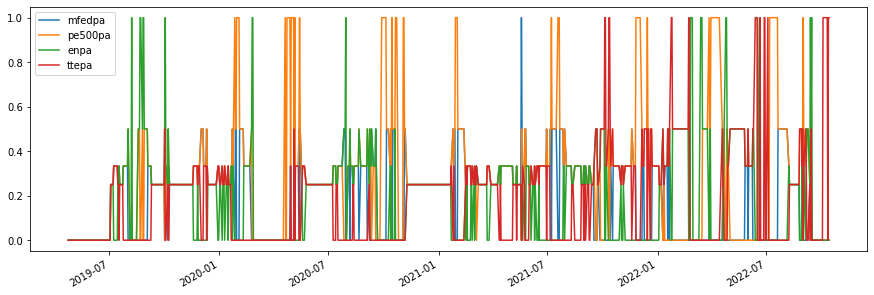

In [71]:
res.plot_security_weights()

<AxesSubplot:title={'center':'weekly Equity Progression'}>

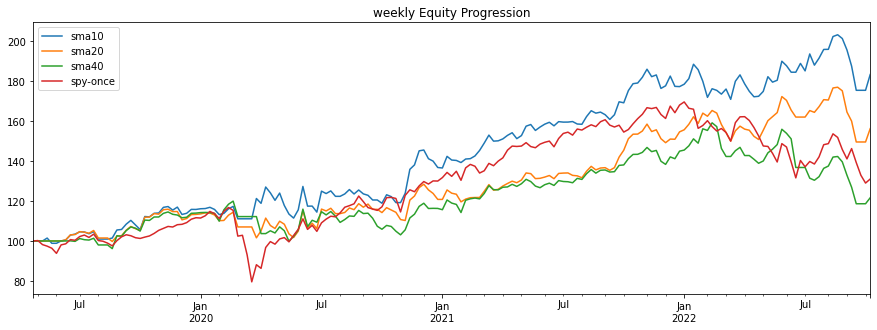

In [72]:
def above_sma(data, sma_per=50, name='above_sma'):
    sma = data.rolling(sma_per).mean()
    s = bt.Strategy(
        name,
        [
            bt.algos.SelectWhere(data > sma),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance(),
        ]
    )
    return bt.Backtest(s, data)

def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(
        name,
        [
            bt.algos.RunOnce(),
            bt.algos.SelectAll(),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance()
        ]
    )
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)

sma10 = above_sma(data, sma_per=10, name='sma10')
sma20 = above_sma(data, sma_per=20, name='sma20')
sma40 = above_sma(data, sma_per=40, name='sma40')

res2 = bt.run(
    sma10,
    sma20,
    sma40,
    long_only_ew('spy', start='2015-01-01', name='spy-once'),
)
res2.plot(freq='w')

In [73]:
res2.display()

Stat                 sma10       sma20       sma40       spy-once
-------------------  ----------  ----------  ----------  ----------
Start                2019-04-24  2019-04-24  2019-04-24  2019-04-24
End                  2022-10-14  2022-10-14  2022-10-14  2022-10-14
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         76.34%      54.96%      17.04%      29.64%
Daily Sharpe         0.94        0.75        0.34        0.44
Daily Sortino        1.54        1.17        0.51        0.66
CAGR                 17.74%      13.44%      4.63%       7.76%
Max Drawdown         -15.13%     -16.92%     -27.79%     -33.72%
Calmar Ratio         1.17        0.79        0.17        0.23

MTD                  0.58%       3.66%       -1.33%      0.13%
3m                   -6.15%      -3.83%      -8.45%      -4.98%
6m                   2.47%       1.73%       -16.91%     -17.62%
YTD                  -1.14%      -0.41%      -19.54%     -23.83%
1Y                   -0.26%   

## SMA crossover strategy

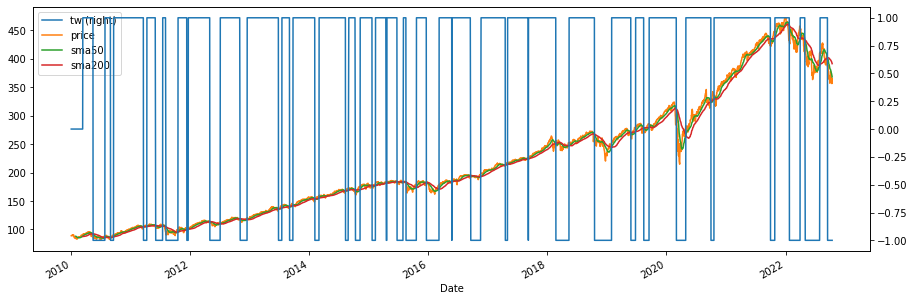

In [74]:
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(20).mean()
sma200 = data.rolling(50).mean()

tw = sma200.copy()
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
tw[sma200.isnull()] = 0.0

tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

<AxesSubplot:title={'center':'Equity Progression'}>

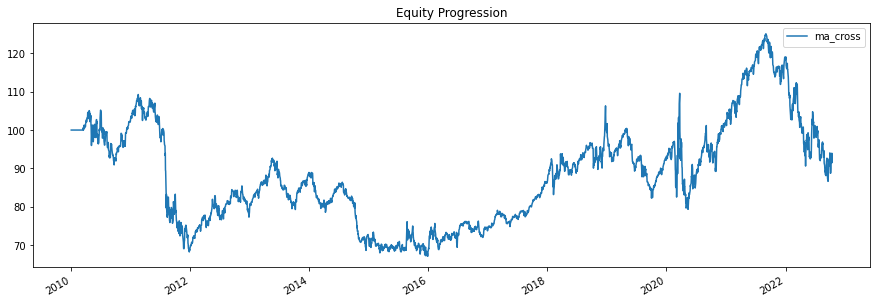

In [75]:
ma_cross = bt.Strategy(
    'ma_cross',
    [
        bt.algos.WeighTarget(tw),
        bt.algos.Rebalance(),
    ]
)
t = bt.Backtest(ma_cross, data)
res = bt.run(t)
res.plot()

## Tree structure

<AxesSubplot:title={'center':'Equity Progression'}>

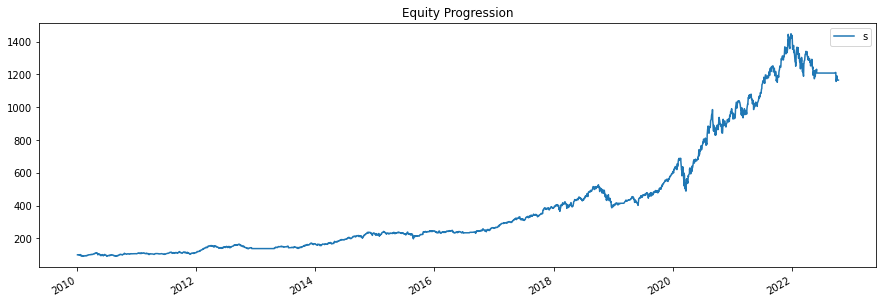

In [76]:
def ma_cross(ticker, start='2010-01-01', short_ma=50, long_ma=200, name='ma_cross'):
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma = data.rolling(long_ma).mean()

    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    s = bt.Strategy(
        name,
        [bt.algos.WeighTarget(tw), bt.algos.Rebalance()],
        [ticker]
    )

    return bt.Backtest(s, data)

t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

data = bt.merge(
    t1.data,
    t2.data,
)

s = bt.Strategy(
    's',
    [
        bt.algos.SelectAll(),
        bt.algos.WeighInvVol(),
        bt.algos.Rebalance(),
    ],
    [
        t1.strategy,
        t2.strategy,
    ]
)
t = bt.Backtest(s, data)
res = bt.run(t)
res.plot()

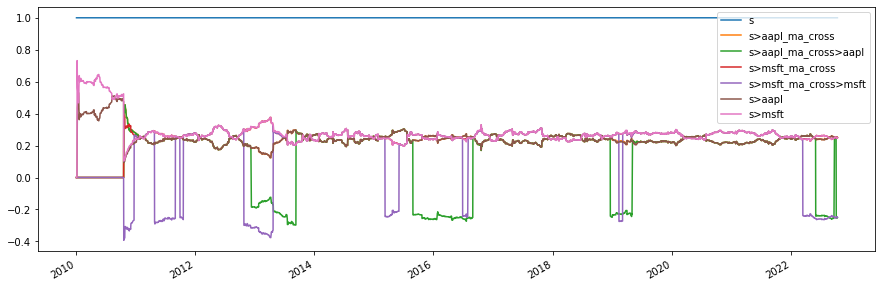

In [77]:
res.plot_weights()